In [1]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import skimage
import os, sys, shutil
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
import argparse
import astropy.io.fits as fits
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import pandas as pd
import json
import cv2
import scipy.ndimage as sndi
import importlib
sys.path.insert(0, '../utils')
import data_utils, run_utils, eval_utils, plot_utils, models

In [ ]:
'''
Meeting 10/4
Need to make sure that both encoder and decoder can do their own tasks as supervised problems
    - Right now dec is mostly symmetrical to enc, but really should not be. For lots of scientific problems, decoder should be deeper
    - If dec is not deep enough, will bias enc to produce
    - More layers, change kernel sizes (if increases, perhaps increase stride to make run faster), etc
    - Shallow network with small kernel should be equiv to deeper network with larger kernel
Should maybe plot images as network goes to better understand what each layer does 
    - NOTE: goal is that each kernel extracts one feature
'''

#### WNET

In [2]:
'''
Quickly summarize trained models
Note on naming scheme
    For input info changes: flux=X (29,31), time_series=T (34), mag=M
    For feat changes: _1, _2 (e.g. med vs med**2 TS 40_5 vs 20_5)
    For train params (loss term wght, loss chan wght) changes: _A, _B, etc 
    For learn and model params (lr, epochs, pad and kernel size) changes: _a, _b, etc 
'''

importlib.reload(eval_utils)
mods = eval_utils.get_wnetDF(modeldir='../../model_runs_seg/MURaM', tag='X')
mods

['WNetXfn_1Ba_newdec', 'WNetXfn_2D', 'WNetX_1Ba', 'TrNetXfn_1Ab', 'WNetXfn_bin1A', 'WNetX_bin1D', 'WNetX_MR1A', 'WNetXfn_bin1C', 'WNetX_2Aa', 'WNetX_bin1B', 'WNetX_1B', 'WNetX_2Ba', 'WNetXfn_2Da', 'WNetX_2A', 'TrNetXfn_1A', 'WNetXfn_3A', 'WNetX_3B', 'WNetXfn_2C', 'WNetXfn_1A', 'WNetXfn_2B', 'WNetXfn_2Db', 'WNetX_1A', 'WNetXfn_2B_act', 'WNetX_bin1A', 'WNetX_3A', 'WNetXfn_3B', 'WNetX_1Ca', 'WNetXfn_1Ba', 'WNetX_1Bb', 'WNetX_bin1C', 'WNetX_2B', 'WNetXfn_2E', 'TrNetXfn_2Aa', 'WNetXfn_bin1D', 'TrNetXfn_1Ac', 'TrNetXfn_2A', 'WNetX_test', 'WNetXfnI_1A']
Skipping WNetX_bin1D; not finished training
Skipping WNetX_MR1A; not finished training
Skipping WNetX_1Bb; not finished training


WNet_name  n_classes                 channels       weights  \
12         TrNetXfn_1A          3                      [X]           [1]   
3         TrNetXfn_1Ab          3                      [X]           [1]   
31        TrNetXfn_1Ac          3                      [X]           [1]   
32         TrNetXfn_2A          3              [X, MedRes]        [1, 1]   
29        TrNetXfn_2Aa          3              [X, MedRes]        [1, 1]   
19            WNetX_1A          3                      [X]           [1]   
8             WNetX_1B          3                      [X]           [1]   
2            WNetX_1Ba          3                      [X]           [1]   
24           WNetX_1Ca          3                      [X]           [1]   
11            WNetX_2A          3              [X, MedRes]        [1, 1]   
6            WNetX_2Aa          3              [X, MedRes]        [1, 1]   
27            WNetX_2B          3              [X, MedRes]        [1, 1]   
9            WNetX_2Ba          3              [X, MedRes]        [1, 1]   
22            WNetX_3A          3  [X, X**3, gradx, grady]  [1, 1, 1, 1]   
14            WNetX_3B          3  [X, X**3, gradx, grady]  [1, 1, 1, 1]   
21         WNetX_bin1A          2                      [X]           [1]   
7          WNetX_bin1B          2                      [X]           [1]   
26         WNetX_bin1C          2                      [X]           [1]   
33          WNetX_test          2                      [X]           [1]   
34         WNetXfnI_1A          3                      [X]           [1]   
16          WNetXfn_1A          2                      [X]        [1, 1]   
25         WNetXfn_1Ba          3                      [X]           [1]   
0   WNetXfn_1Ba_newdec          3                      [X]           [1]   
17          WNetXfn_2B          3              [X, MedRes]        [1, 1]   
20      WNetXfn_2B_act          3              [X, MedRes]        [1, 1]   
15          WNetXfn_2C          3              [X, MedRes]        [1, 2]   
1           WNetXfn_2D          3              [X, MedRes]        [1, 2]   
10         WNetXfn_2Da          3              [X, MedRes]        [1, 2]   
18         WNetXfn_2Db          3              [X, MedRes]        [1, 2]   
28          WNetXfn_2E          3              [X, MedRes]        [1, 2]   
13          WNetXfn_3A          3  [X, X**3, gradx, grady]  [1, 1, 1, 1]   
23          WNetXfn_3B          3  [X, X**3, gradx, grady]  [1, 1, 1, 1]   
4        WNetXfn_bin1A          2                      [X]           [1]   
5        WNetXfn_bin1C          2                      [X]           [1]   
30       WNetXfn_bin1D          2                      [X]           [1]   

    smth_wgt  chsn_wght  nct_wgt  cont_wght   pad_mode  k_size  dec_depth  \
12         1        NaN        1        NaN  replicate       3        NaN   
3          1        1.0        1        0.0  replicate       3        7.0   
31         1        1.0        1        0.0  replicate       3        4.0   
32         1        NaN        1        NaN  replicate       3        NaN   
29         1        NaN        1        NaN    reflect       3        NaN   
19        10        NaN        1        NaN      zeros       3        NaN   
8         10        NaN        1        NaN      zeros       3        NaN   
2         10        NaN        1        NaN  replicate       3        NaN   
24        20        NaN        1        NaN  replicate       3        NaN   
11        10        NaN        1        NaN  replicate       3        NaN   
6         10        NaN        1        NaN    reflect       3        NaN   
27        10        NaN        1        NaN  replicate       3        NaN   
9         10        NaN        1        NaN    reflect       3        NaN   
22        10        NaN        1        NaN  replicate       3        NaN   
14        20        NaN        1        NaN  replicate       3        NaN   
21         0        NaN        1        NaN 

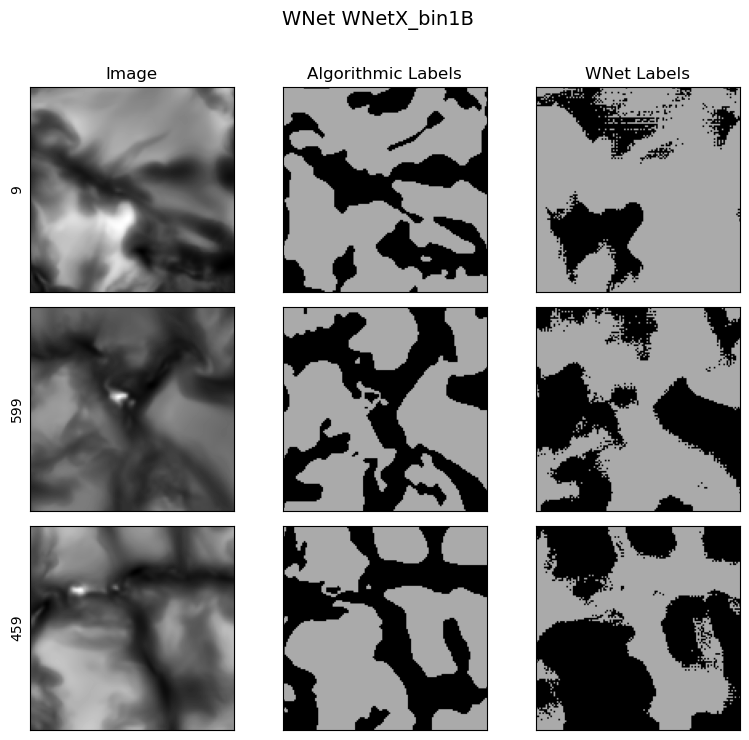

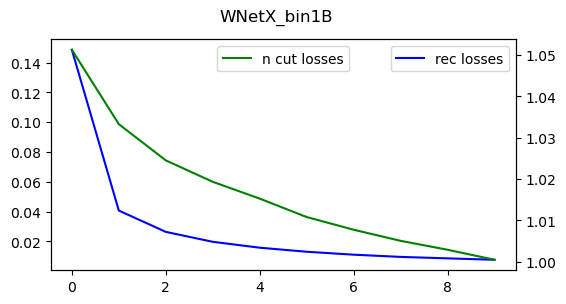

In [23]:
'''
Display a random sample of images for one model
'''
importlib.reload(plot_utils)
wnet_name = 'WNetX_bin1B' #'TrNetXfn_2A' #'WNetXfn_1Ba_newdec' # 'TrNetXfn_2Aa' #'WNetXfnI_1A' # 'WNetMfn_1E' 
fig = plot_utils.plot_preds_one_wnet(wnet_name)
plt.savefig(f'../../model_runs_seg/MURaM/{wnet_name}/WNet{wnet_name}_val_examples') # 3822,  3481, 2952, 3200
fig = plot_utils.plot_loss_one_wnet(wnet_name)

['TrNetXfn_1A', 'TrNetXfn_1Ab', 'TrNetXfn_1Ac', 'TrNetXfn_2A', 'TrNetXfn_2Aa']


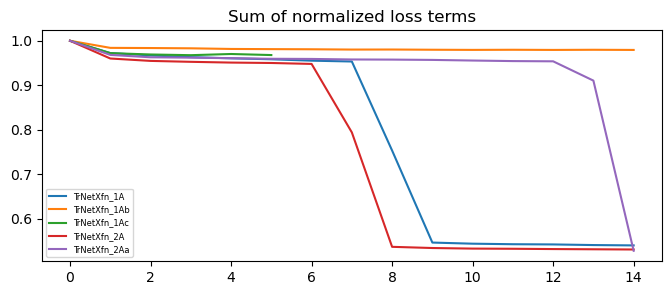

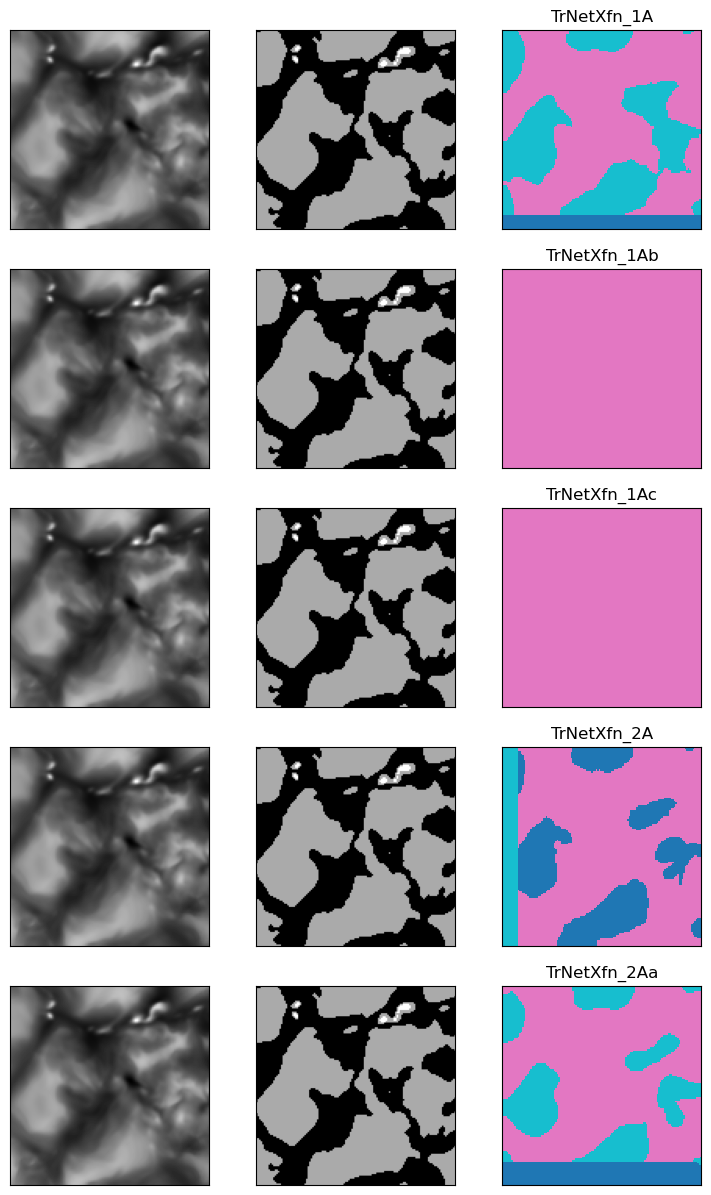

In [3]:
'''
Compare all models (ugly)
'''
importlib.reload(plot_utils)
ignore = [] #['WNet_M1A', 'WNetM_1A_again', 'WNetM_1C','WNetXfn_2B', 'WNetXfn_3B','WNetXfn_1A'] #['WNetXfn_1Ba','WNetXfn_bin1A','WNetXfn_3B','WNetXfn_3A'] #['WNetX_2Aa', 'WNetX_1B', 'WNetX_2A','WNetX_1A']
ms = [m for m in mods['WNet_name'] if m not in ignore and 'fn' in m and 'Tr' in m]
print(ms)
fig = plot_utils.compare_wnet_loss(wnet_names=ms, loss_term='both')
fig = plot_utils.compare_wnet_preds_ugly(wnet_names=ms)
plt.savefig('ExamplePredictions_OneImage.png')

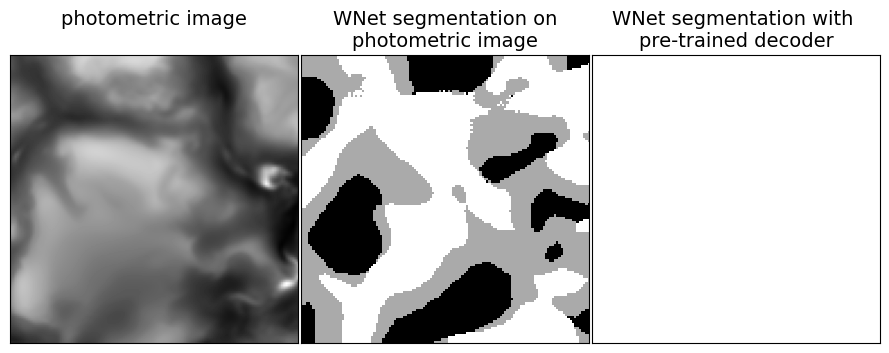

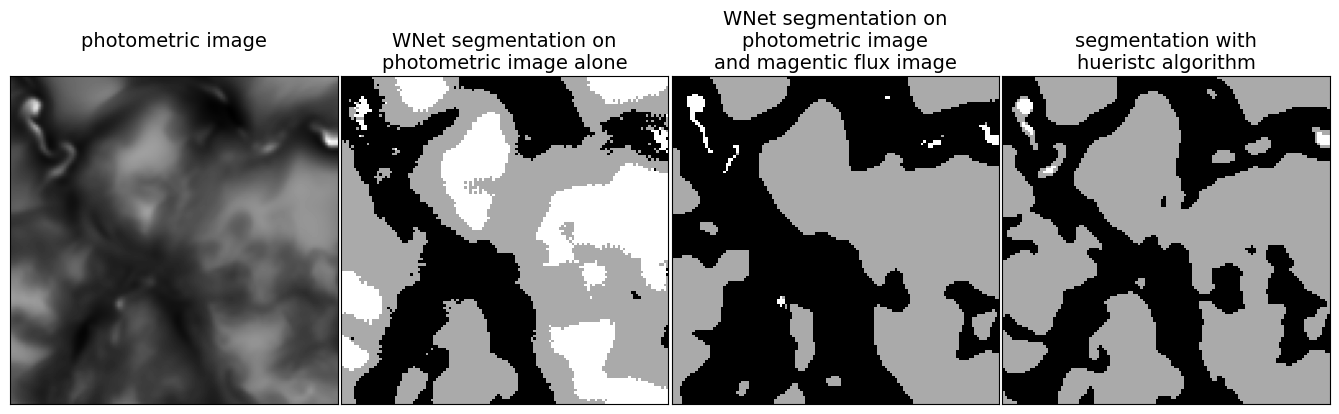

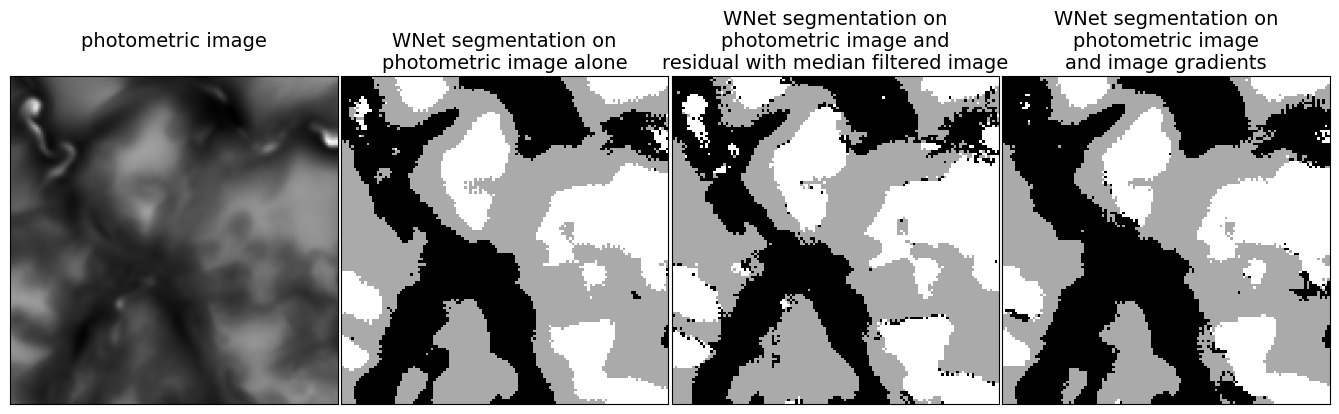

In [9]:
'''
Compare models -nice plots for poster/paper/presentation
'''
importlib.reload(eval_utils)
importlib.reload(plot_utils)
# full norm
# fig = plot_utils.compare_wnet_preds(wnet_names=['WNetXfn_2D','WNetMfn_1E'], add_algseg=True) # full norm, magnetic flux
# fig = plot_utils.compare_wnet_preds(wnet_names=['WNetTfn_1A', 'WNetTfn_1D']) # full norm, timeseries
# fig = plot_utils.compare_wnet_preds(wnet_names=['WNetXfn_bin1A', 'WNetXfn_bin1C','WNetXfn_bin1D']) # full norm, binary
fig = plot_utils.compare_wnet_preds(wnet_names=['WNetXfn_2D', 'TrNetXfn_1Ac']) 
# individual norm
fig = plot_utils.compare_wnet_preds(wnet_names=['WNetX_1Ba','WNetM_1E'], add_algseg=True) # individual norm, magnetic flux
# fig = plot_utils.compare_wnet_preds(wnet_names=['WNetT_1C', 'WNetT_1D']) # individual norm, timeseries
# fig = plot_utils.compare_wnet_preds(wnet_names=['WNetX_bin1A', 'WNetX_bin1B', 'WNetX_bin1C']) # individual norm, binary
fig = plot_utils.compare_wnet_preds(wnet_names=['WNetX_1Ba', 'WNetX_3B', 'WNetX_3A']) # individual norm, 
#fig = plot_utils.compare_wnet_preds(wnet_names=['WNetX_1B', 'WNetX_2Ba','WNetX_1Ba',]) #'WNetX_2Aa']) # individual norm, padding modes 

RUNNING EXPERIMENT WNetX_test 
exp dict: {'WNet_name': 'WNetX_test', 'sub_dir': 'MURaM', 'n_classes': 2, 'channels': ['X'], 'weights': [1], 'img_dir': 'UNetData_MURaM/fullnorm_images/', 'seg_dir': 'UNetData_MURaM/seg_images/', 'img_size': 128, 'randomSharp': 'False', 'smooth_wght': 0, 'blob_wght': 0, 'ncut_wght': 1, 'padding_mode': 'replicate', 'kernel_size': 3, 'reconstruct_mag': 'False', 'inject_brightmasks': 'False', 'num_epochs': 10, 'batch_size': 16, 'learning_rate': 0.001}
Experiment output dir ../../model_runs_seg/MURaM/WNetX_test/ already exists - contents will be overwritten
Copying exp dict into ../../model_runs_seg/MURaM/WNetX_test//exp_file.json
Loading data from UNetData_MURaM/fullnorm_images/
Train data:
	11428 obs, broken into 715 batches
	Each batch has data of shape torch.Size([16, 1, 128, 128]), e.g. 16 images, [128, 128] pixels each, 1 layers (features)
	Each batch has labels of shape torch.Size([16, 2, 128, 128]), e.g. 16 images, [128, 128] pixels each, 2 layers (cl

FileNotFoundError: [Errno 2] No such file or directory: '/projects/lezu7058/SolarML_2023/Solar_Segmentation/model_runs_seg/MURaM/WNetX_test/traindata_WNetX_test.png'

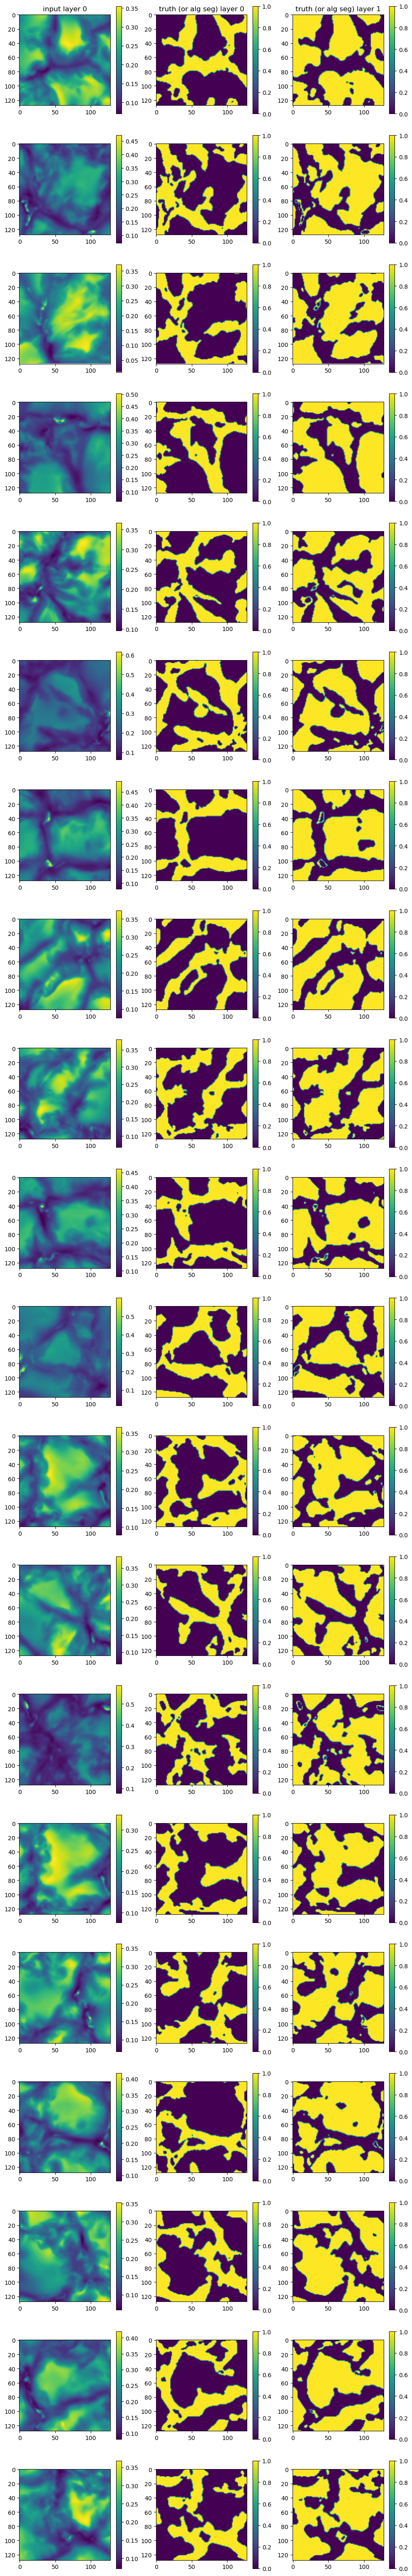

In [9]:
'''
Run WNet in notebook for debugging
'''
import sys, json, importlib
sys.path.insert(0, '../utils')
import data_utils, run_utils, models, loss_funcs
sys.path.insert(0, '../')
import run_WNet
importlib.reload(data_utils); importlib.reload(run_WNet); importlib.reload(loss_funcs)

exp_dicts = json.load(open('../../model_runs_seg/MURaM/WNetX_test/exp_file.json'))#'../../Solar_Segmentation/exp_todo/wnet_exp_file_10.json')) #'../../model_runs_seg/MURaM/WNetT_2C/exp_file.json')) # # '../../model_runs_seg/MURaM/WNetX_bin1A/exp_file.json'))#
if isinstance(exp_dicts, dict): # If experiment file is a single dict, not a list of dicts
    exp_dicts = [exp_dicts]
for d in exp_dicts:
    print(f'RUNNING EXPERIMENT {d["WNet_name"]} \nexp dict: {d}')
    run_WNet.run_wnet_model(d, gpu='False', test_only=False)
    print(f'DONE')
print('FINISHED ALL EXPERIMENTS')

NameError: name 'out' is not defined

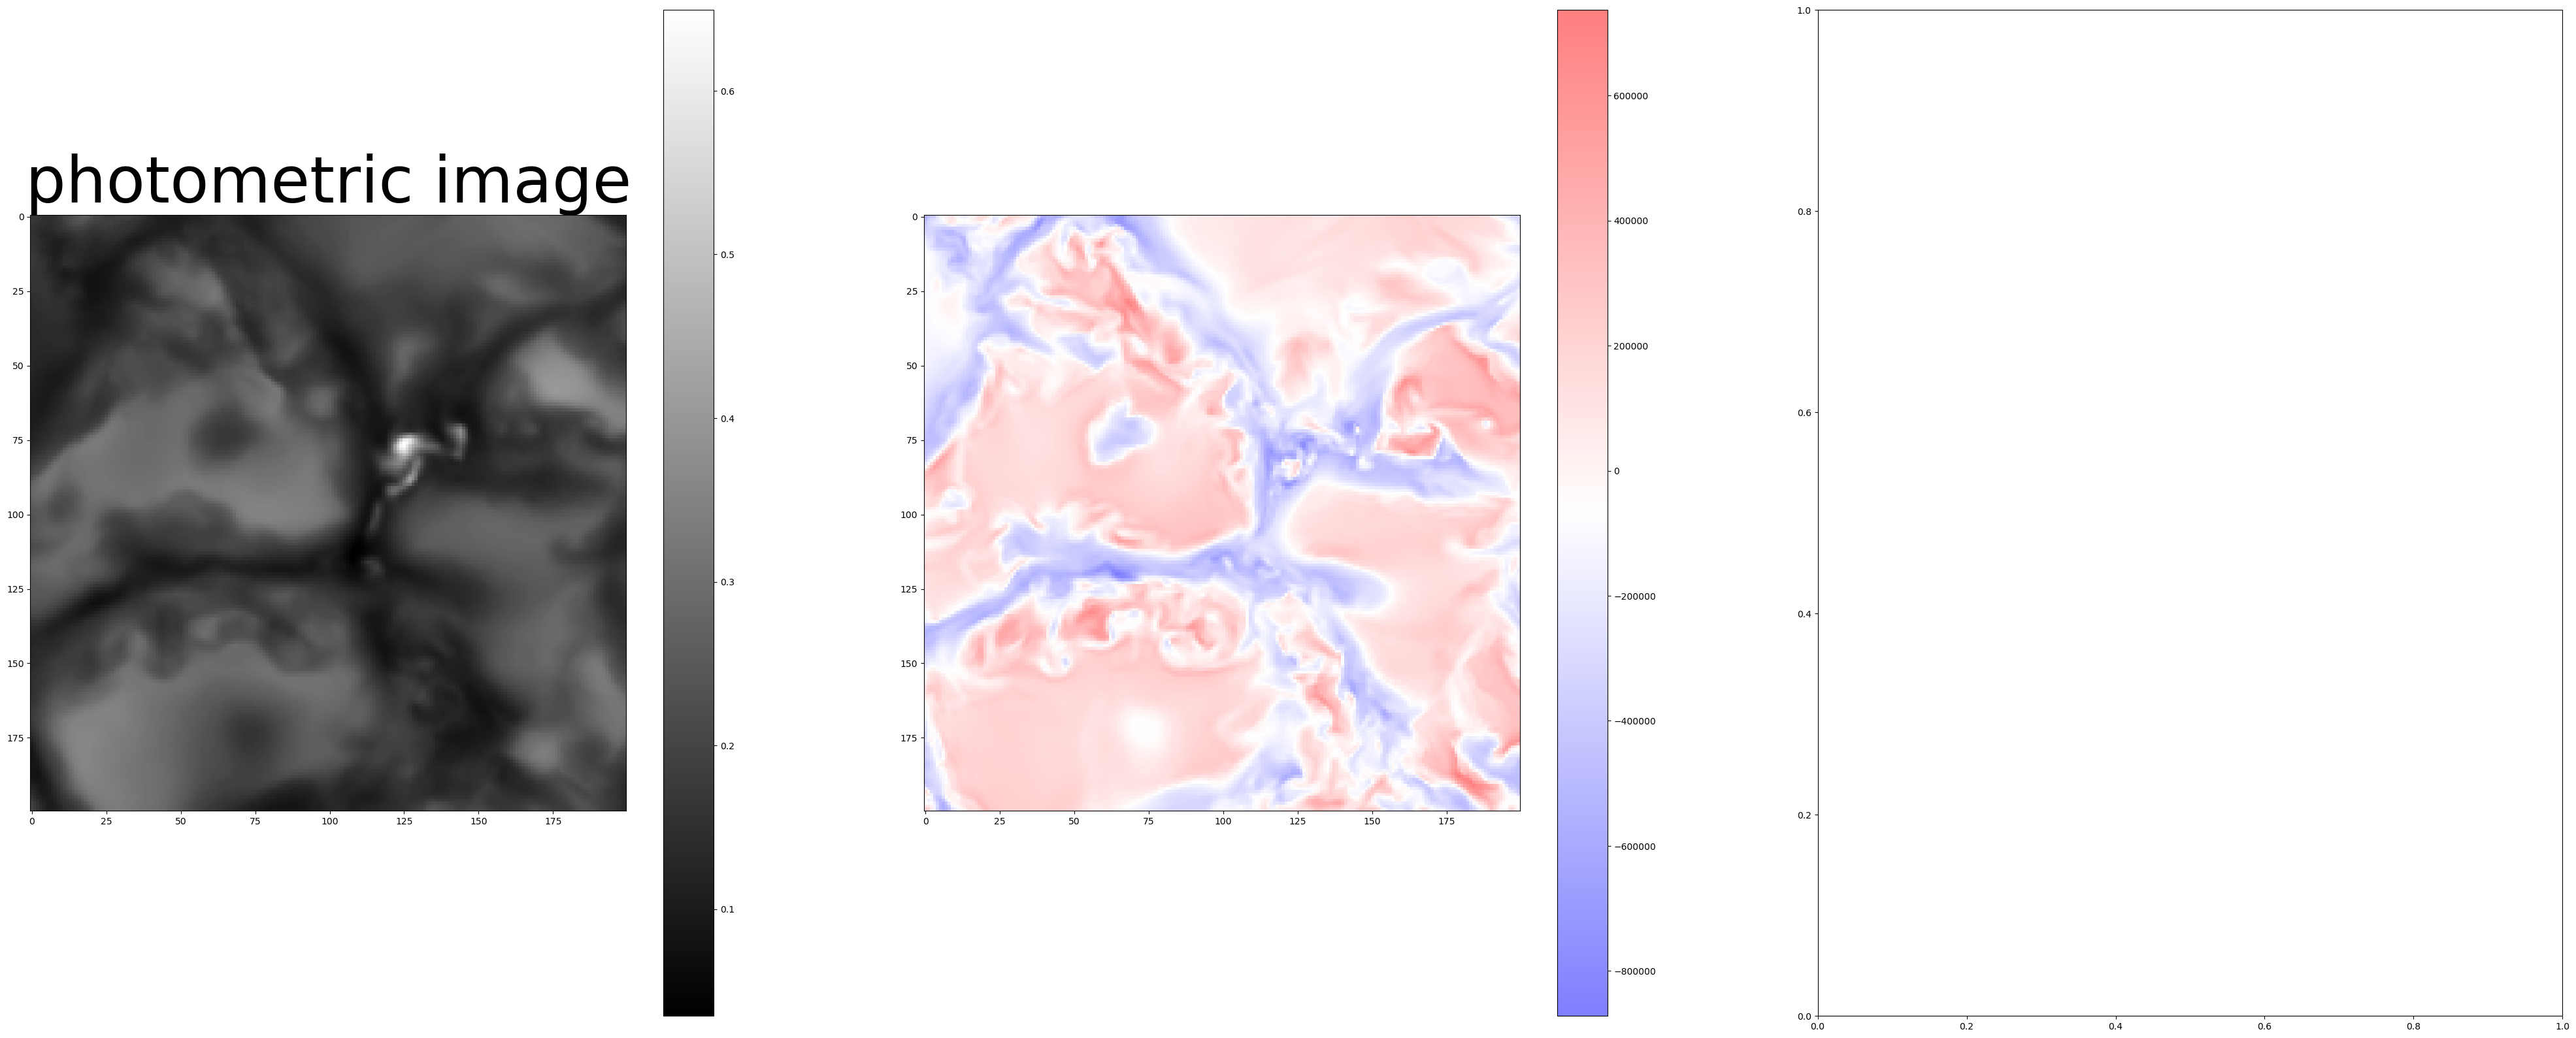

In [32]:
'''
Segmentation over Velocity maps
'''
sys.path.insert(0, '../utils')
import models

start = 0
N = 200 #50
quiver_step = 8
import torchvision.transforms as transforms
resize = transforms.Resize(128, antialias=None)
unresize = transforms.Resize(N, antialias=None) 
colors = LinearSegmentedColormap.from_list('', [plt.cm.tab10(0), plt.cm.tab10(9), plt.cm.tab10(6)])

vx = fits.open('../../../../../scratch/alpine/lezu7058/SolarML_2023/Data/MURaM_vx/tau_slice_1.000.018000_vx.fits.gz')[0].data[start:start+N,start:start+N]
vy = fits.open('../../../../../scratch/alpine/lezu7058/SolarML_2023/Data/MURaM_vy/tau_slice_1.000.018000_vy.fits.gz')[0].data[start:start+N,start:start+N]
vz = fits.open('../../../../../scratch/alpine/lezu7058/SolarML_2023/Data/MURaM_vz/tau_slice_1.000.018000_vz.fits.gz')[0].data[start:start+N,start:start+N]
img = fits.open('../../Data/MURaM/fullNorm_I_out.018000.fits.gz')[0].data[start:start+N,start:start+N].newbyteorder().byteswap()
img = np.array(resize(torch.from_numpy(np.expand_dims(img, axis=0)))).squeeze()
algseg = fits.open('../../Data/MURaM/SEGv2_I_out.018000.fits.gz')[0].data[start:start+N,start:start+N]
algseg[algseg == 0.5] =1.0
mag = fits.open('../../Data/MURaM_mag/tau_slice_1.000.018000_Bz.fits.gz')[0].data[start:start+N,start:start+N].newbyteorder().byteswap()
mag = np.array(resize(torch.from_numpy(np.expand_dims(mag, axis=0)))).squeeze()
mag = mag**2
mag = (mag - np.mean(mag))/np.std(mag) 

# X = np.zeros((1, 2, img.shape[0], img.shape[1]), dtype=np.float32)
# X[:,0,:,:] = img
# X[:,1,:,:] = mag
# X = torch.tensor(X)
# model = models.WNet(n_classes=3, dec_ch_mul=64, in_chans=2, out_chans=2, kernel_size=3, padding_mode='replicate', reconstruct_mag=False)
#         # in_chans, n_classes, out_chans=1000, dec_depth=4, double_dec=False, dec_ch_mul=64, kernel_size=3
# model.load_state_dict(torch.load(f'../../model_runs_seg/MURaM/WNetXfn_bin1A/WNetXfn_bin1A.pth')) # WNetM_1E/WNetM_1E.pth # 'WNetXfn_bin1A', 'WNetXfn_bin1C','WNetXfn_bin1D'
# probs = model(X, compute_dec=False) # defualt is to return dec, but we want seg
# preds = np.argmax(probs.detach().numpy(), axis=1).astype(float) # turn probabilities [n_obs, n_class, n_pix, n_pix] into predicted class labels [n_obs, n_pix, n_pix]
# preds[preds == 2.0] = 1.5 # change from idx to class value 0 -> 0 (IG), 1 -> 1 (G), 2 -> 1.5 (BP)
# preds = np.squeeze(preds)
# preds = np.array(unresize(torch.from_numpy(np.expand_dims(preds, axis=0)))).squeeze()
# out = np.zeros_like(preds)
# out[preds == 1.0] = 0.0
# out[preds == 1.5] = 1.0
# out[preds == 0.0] = 1.5
img = np.array(unresize(torch.from_numpy(np.expand_dims(img, axis=0)))).squeeze()

# fig, axs = plt.subplots(1, 3, figsize=(10, 30))
# axs[0].imshow(img, cmap='gist_gray')
# axs[0].set_title('Image')
# axs[1].imshow(out, vmin=0, vmax=1.5, interpolation='none', cmap=colors, alpha=0.5)
# X, Y = np.meshgrid(np.linspace(0,np.shape(vx)[0],np.shape(vx)[0]), np.linspace(0,np.shape(vx)[0],np.shape(vx)[0]))
# axs[1].quiver(X[::quiver_step,::quiver_step], Y[::quiver_step,::quiver_step], vx[::quiver_step,::quiver_step], vy[::quiver_step,::quiver_step])
# axs[1].set_title(r'$\vec{V}$ over WNet Segmentation')
# axs[2].imshow(algseg, vmin=0, vmax=1.5, interpolation='none', cmap=colors, alpha=0.5)
# axs[2].quiver(X[::quiver_step,::quiver_step], Y[::quiver_step,::quiver_step], vx[::quiver_step,::quiver_step], vy[::quiver_step,::quiver_step])
# axs[2].set_title(r'$\vec{V}$ over Algorithmic Segmentation')
# for ax in axs.flat:
#     ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.05)

# fig, axs = plt.subplots(1, 3, figsize=(10, 30))
# axs[0].imshow(img, cmap='gist_gray')
# axs[0].set_title('Image')
# axs[1].imshow(vz[0:110,0:100], cmap='bwr', alpha=0.5)
# out1 = np.ones_like(out)*np.NaN
# out1[out == 1] = 1
# out1[out == 1.5] = 1
# axs[1].imshow(out1[0:110,0:100], vmin=0, vmax=1.5, cmap='gist_gray', alpha=0.5)
# import cv2
# cv2.imwrite("temp_img.png", out) 
# edges = np.array(cv2.Canny(cv2.imread("temp_img.png"),0,1.5))
# edges1 = np.where(edges > 0, 1, np.NaN) 
# axs[1].imshow(edges1[0:110,0:100])
# axs[1].set_title(r'WNet Segmentation over $V_z$')
# axs[2].imshow(vz[0:110,0:100], cmap='bwr', alpha=0.5)
# alg1 = np.ones_like(algseg)*np.NaN
# alg1[algseg == 1] = 1
# alg1[algseg == 1.5] = 1
# axs[2].imshow(alg1[0:110,0:100], vmin=0, vmax=1.5, cmap='gist_gray', alpha=0.5)
# cv2.imwrite("temp_img.png", algseg) 
# edges = np.array(cv2.Canny(cv2.imread("temp_img.png"),0,1.5))
# edges1 = np.where(edges > 0, 1, np.NaN) 
# #axs[2].imshow(edges1[0:110,0:100])
# axs[2].set_title(r'Algorithmic Segmentation over $V_z$')
# for ax in axs.flat:
#     ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.05)

fig, axs = plt.subplots(1, 3, figsize=(50, 20))
im0 = axs[0].imshow(img, cmap='gist_gray'); plt.colorbar(im0, ax=axs[0])
axs[0].set_title('photometric image', fontsize=70)
im = axs[1].imshow(vz, cmap='bwr', alpha=0.5); plt.colorbar(im, ax = axs[1])
out1 = np.ones_like(out)*np.NaN
out1[out == 1] = 1
out1[out == 1.5] = 1
axs[1].imshow(out1, vmin=0, vmax=1.5, cmap='gist_gray', alpha=0.5)
import cv2
cv2.imwrite("temp_img.png", out) 
edges = np.array(cv2.Canny(cv2.imread("temp_img.png"),0,1.5))
edges1 = np.where(edges > 0, 1, np.NaN) 
axs[1].imshow(edges1)
axs[1].set_title(r'WNet segmentation over $V_z$', fontsize=70)
axs[2].imshow(out1, vmin=0, vmax=1.5, cmap='gist_gray', alpha=0.5)
dvx_dx, dvx_dy = np.gradient(vx)
dvy_dx, dvy_dy = np.gradient(vy)
div = dvx_dy + dvy_dx
axs[2].imshow(div, alpha=0.7)
axs[2].imshow(edges1)
axs[2].set_title('WNet segmentation over\nhorizantal divergence', fontsize=70)
for ax in axs.flat:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.02)


# div = dvx/dx+dvy/dy

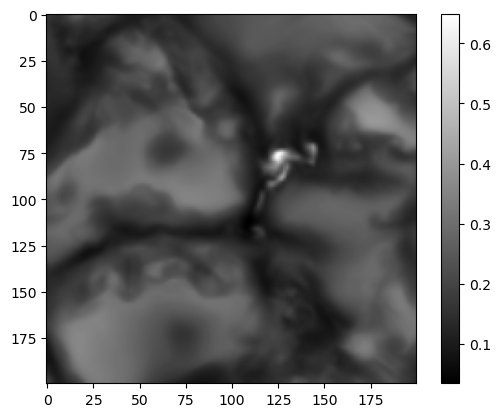

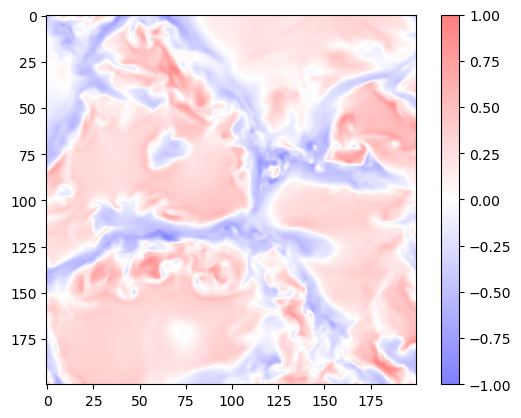

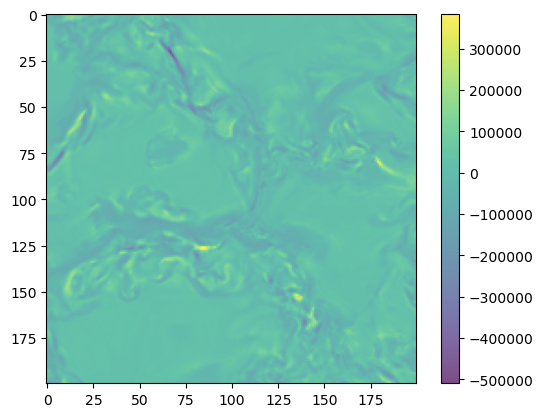

In [35]:
dvx_dx, dvx_dy = np.gradient(vx)
dvy_dx, dvy_dy = np.gradient(vy)
div = dvx_dy + dvy_dx
#plt.figure(); im = plt.imshow((div-np.min(div))/(np.max(div)-np.min(div)), alpha=0.7); plt.colorbar(im)
plt.figure(); im = plt.imshow(img,cmap='gist_gray'); plt.colorbar(im)
vz = -1 + ( ((vz - np.min(vz)) * (1 + 1)) / (np.max(vz) - np.min(vz)))
plt.figure(); im = plt.imshow(vz,cmap='bwr', alpha=0.5); plt.colorbar(im)
plt.figure(); im = plt.imshow(div,alpha=0.7); plt.colorbar(im)

In [20]:
#   os.listdir('../../../../../scratch/alpine/lezu7058/SolarML_2023/Data/MURaM_vx/')
os.path.exists('../../../../../scratch/alpine/lezu7058/Solar_ML/Data/MURaM_vx/')
os.path.exists('../../../../../scratch/alpine/lezu7058/SolarML_2023/Data/MURaM/')

False

#### Traditional 

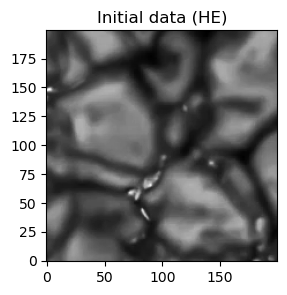

<Figure size 640x480 with 0 Axes>

In [4]:
# Get data
path = "../../Data/FirstLight.fits"
data = fits.open(path)[0].data
labels = np.squeeze(fits.open("../../Data/SEGv2_FirstLight.fits")[0].data) # just to check against

# Cut and flatten
data = data[100:300, 100:300]
labels = labels[100:300, 100:300]
dataflat = data.reshape(-1)

# Plot for comparison
plt.figure(figsize=(3, 3))
plt.imshow(data, cmap='gray', origin='lower')
plt.title('Initial data (HE)')
plt.figure()

# Create features and put into df (skip kernel feature for now - contain inf and probably not super useful anyway)
df = pd.DataFrame()
df['OG_value'] = dataflat
df = data_utils.add_gradient_feats(df, data) # Add value of (non-HE) gradient as feature
df = data_utils.add_sharpening_feats(df, dataflat) # Add value of sharpening filters as features RIGHT NOW JUST SQUARED

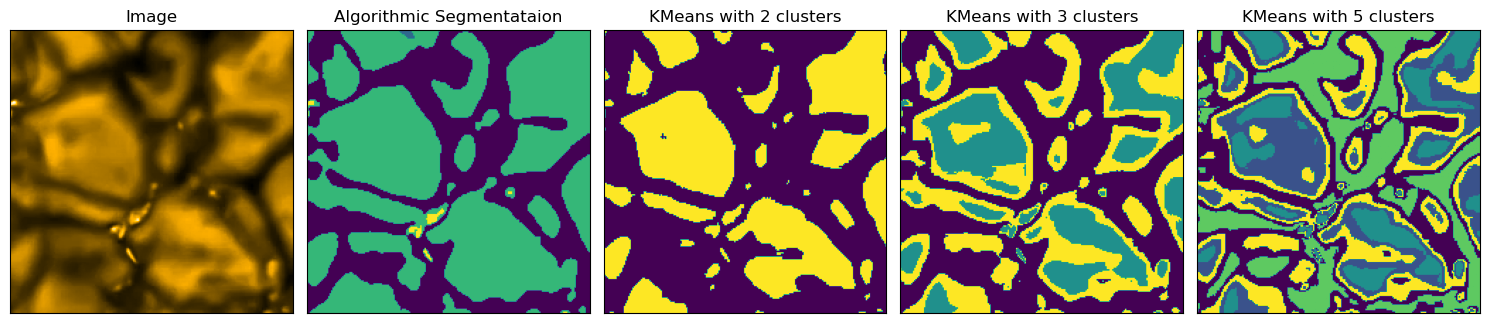

In [37]:
'''
KMeans (best)
    Clusters by separating into n groups of equal variance, minimizing within-cluster sum-of-squares
    Overall, this seems to overestimate IGM
    Could try using large n_clusters, then combineing.
'''
import skimage as sk
from sklearn.cluster import KMeans

# # Explore hyperparameters
# n_clusterss = [2, 3, 5, 7]
# inits = ['k-means++']#, 'random'] # can also try passing locs of centers if use another alg to determine

# dict = {}
# i = 0
# for n_clusters in n_clusterss:
#     for init in inits:
#         preds_flat = KMeans(n_clusters=n_clusters, init=init, n_init=10).fit(df.values).labels_
#         preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
#         preds = data_utils.post_process(preds) # make sure IG is assigned to 0, G to 1
#         dict[str(i)] = [n_clusters, init, preds]
#         i += 1
#         pct_correct = len(np.where(preds.reshape(-1)==labels.reshape(-1))[0])/len(preds.reshape(-1))
#         print('    n_clusters='+str(n_clusters)+', init='+str(init)+ ', "accuracy":', pct_correct)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
# fig.suptitle('KMeans')
# axs = [ax1, ax2]
# for i in range(len(axs)):
#     n_clusters =  dict[str(i)][0]
#     init = dict[str(i)][1]
#     preds = dict[str(i)][2]
#     axs[i].imshow(preds, origin='lower')
#     axs[i].set_title('n_clusters='+str(n_clusters)+', init='+str(init))


# # With "best" hyperparameters
# n_clusters = 7
# preds_flat = KMeans(n_clusters=n_clusters, init='random', n_init=10).fit(df.values).labels_
# preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))

# def kmeans_to_seg(preds, data, resolution=0.016, bp_max_size=0.15):
#     seg = np.zeros_like(data)*np.NaN
#     # HE
#     data_norm = ((data - np.nanmin(data))/(np.nanmax(data) - np.nanmin(data))) * 225 # min-max normalization to [0, 225] 
#     data_HE = sk.filters.rank.equalize(data_norm.astype(int), footprint=sk.morphology.disk(250))
#     data_HE = data_HE[100:300, 100:300]
#     bp_min_pix = (bp_max_size / resolution)**2 # 87
#     bp_min_flux = np.nanmean(data) + 0.25 * np.nanstd(data) 
#     ig_max_flux = np.nanmean(data) - 0.25 * np.nanstd(data)
#     labeled_preds = skimage.measure.label(preds + 1, connectivity=2)
#     values = np.unique(labeled_preds) 
#     for value in values:
#         datavals = data[labeled_preds == value].flatten()
#         if (np.nanmean(datavals) <= ig_max_flux):
#             seg[labeled_preds == value] = 0
#         if (np.nanmean(datavals) > ig_max_flux): #and (len(datavals) > bp_min_pix): #(np.nanmean(datavals) < bp_min_flux):
#             seg[labeled_preds == value] = 1
#             if (len(datavals) < bp_min_pix) and np.max(datavals) > bp_min_flux:
#                 seg[labeled_preds == value] = 1.5
#     return seg

# seg = kmeans_to_seg(preds, data)
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.5))
# fig.suptitle('KMeans (n_clusters=7, init="random")')
# ax1.imshow(data, cmap='gray', origin='lower'); ax1.set_title('data')
# ax2.imshow(preds, origin='lower'); ax2.set_title('kmeans preds')
# ax3.imshow(seg, origin='lower'); ax3.set_title('kmeans pred -> seg')
# fig, axs = plt.subplots(n_clusters, 1, figsize=(7, 2*n_clusters))
# i = 0
# axs[-1].set_ylabel('Flux')
# for group in np.unique(preds):
#     axs[i].hist(data[preds == group], bins=20); axs[i].set_ylabel(f'Group {i}')
#     i += 1


# Figure for paper
n_clusters = [2, 3, 5]

import sunpy.visualization.colormaps as cm
fig, axs = plt.subplots(1, 2+len(n_clusters), figsize=(15, 4))
axs[0].imshow(data, cmap=plt.get_cmap('goes-rsuvi171'), origin='lower'); axs[0].set_title('Image')
axs[1].imshow(labels, origin='lower'); axs[1].set_title('Algorithmic Segmentataion')
for i in range(len(n_clusters)):
    n_clust = n_clusters[i]
    preds_flat = KMeans(n_clusters=n_clust, init=init, n_init=10).fit(df.values).labels_
    preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
    #preds = data_utils.post_process(preds, data) # make sure IG is assigned to 0, G to 1
    if int(preds[10,10]) != 0:
        preds = -1 * preds
    axs[i+2].imshow(preds, origin='lower')
    axs[i+2].set_title(f'KMeans with {n_clust} clusters')
for ax in axs.flat:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0)

In [ ]:
'''
Agglomorative Clustering
    Build clusters by finding closest pairs, merging iteratively 
    Does best with 3 clusters, 'complete' linkage, 'euclidean' metric:
    Without gradient feature, 3rd cluster becomes rings around granules, not brightpoints
    With gradient feature, maybe finds dim middles?
'''

from sklearn.cluster import AgglomerativeClustering

# Explore hyperparameters
n_clusterss = [2, 3] 
metrics = ['euclidean'] #  'l1', 'manhattan' seem to do similarly (at least with n_clusters=2) 
linkages = ['complete', 'ward'] # 'average' and 'single' do terrible

dict = {}
i = 0
for n_clusters in n_clusterss:
    for metric in metrics:
        for linkage in linkages:
            preds_flat = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage).fit(df.values).labels_
            preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
            preds = data_utils.post_process(preds) # make sure IG is addigned to 0, G to 1
            dict[str(i)] = [n_clusters, metric, linkage, preds]
            i += 1
            pct_correct = len(np.where(preds.reshape(-1)==labels.reshape(-1))[0])/len(preds.reshape(-1))
            print('    n_clusters='+str(n_clusters)+', linkage='+str(linkage)+ ', "accuracy":', pct_correct)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle('AgglomorativeClustering')
axs = [ax1, ax2]
for i in range(len(axs)):
    n_clusters =  dict[str(i)][0]
    metric = dict[str(i)][1]
    linkage = dict[str(i)][2]
    preds = dict[str(i)][3]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('n_clusters='+str(n_clusters)+', linkage='+str(linkage))

In [ ]:
'''
DBSCAN 
    Clusters by identifying areas of high density separated by areas of low density 
    MUCH faster than OPTICS, but same very "poor" results
'''

from sklearn.cluster import DBSCAN

# Explore hyperparameters
epss = [10, 30] # must be larger for more features (0.5 works fine for 1 feature)
min_sampless = [50, 100, 200]
metric = 'euclidean'
algorithm = 'auto'

dict = {}
i = 0
for eps in epss:
    for min_samples in min_sampless:
        preds_flat = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm, n_jobs=3).fit(df.values).labels_
        preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
        dict[str(i)] = [eps, min_samples, preds]
        i += 1

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('DBSCAN', color='white')
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in range(len(axs)):
    eps =  dict[str(i)][0]
    min_samples = dict[str(i)][1]
    preds = dict[str(i)][2]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('eps='+str(eps)+', min_samps='+str(min_samples), color=tc)

#### MISC

In [94]:
'''
Calculate padding size for given kernel to keep dims same
    out_dim = ((input_dim - kernel_size + 2*padding)/stride) + 1 --> ((input_dim -1)*stride - input_dim + kernel_size)/2 = padding
    So with stride = 1, need padding = (kernel_size - 1)/2
What about output_padding in conv transpose?
    Needs to be 1 when kernel_size is 3, needs to be 0 when kernel_size is 5..
'''

kernel_size = 5
padding = int((kernel_size - 1)/2)

inp = torch.rand(16,3,128,128)
conv = torch.nn.Conv2d(3, 64, kernel_size=kernel_size, padding=padding, stride=1) #torch.nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=1)
out = conv(inp) 
print(inp.shape)
print(out.shape)

'''
output_size = stride × (input_size−1) + kernel_size−2 × padding + output_padding
    e.g. output_padding = input_dim - kernel_size*padding - stride*(input_dim-1) 
output_size = stride × (input_size−1) + effective_kernel_size−2 × padding + output_padding
    e.g. output_padding = input_dim - stride*(input_dim - 1) - eff_kernel_size + 2*padding
                          input_dim − stride×(input_size - 1)−effective_kernel_size+2×padding
'''

# dilation = 1  # NOTE: could perhaps use a dilation factor in the "up" layers instead of using ConvTranspose layers
output_padding = 
convtransp = torch.nn.ConvTranspose2d(64, 3, kernel_size=kernel_size, padding=padding, stride=2, output_padding=output_padding) 
rec_inp = convtransp(out)
print(rec_inp.shape)

torch.Size([16, 3, 128, 128])
torch.Size([16, 64, 128, 128])
torch.Size([16, 3, 256, 256])


In [21]:
'''
Rename models
    For input info changes: flux=X (29,31), time_series=T (34), mag=M
    For feat changes: _1, _2 (e.g. med vs med**2 TS 40_5 vs 20_5)
    For train params (loss term wght, loss chan wght, lr) changes: _A, _B, etc 
    For model params (pad and kernel size) changes: _a, _b, etc 
    Add subfolders to seperate DS used 
'''

# # Remove name labels on saved epoch predictions and losses so that only need to re-name exp folders
# exp_folders = [f for f in os.listdir('../../WNet_runs/') if 'nm' in f]
# for exp_folder in exp_folders:
#     pngs = [f for f in os.listdir(f'../../WNet_runs/{exp_folder}/') if '.png' in f]
#     for png in pngs:
#         new_name = png[png.find("_e")+1:] # oops?
#         os.rename(f'../../WNet_runs/{exp_folder}/{png}', f'../../WNet_runs/{exp_folder}/{new_name}')
#         pngs = [f for f in os.listdir(f'../../WNet_runs/{exp_folder}/') if '.png' in f]
#     name = exp_folder.replace('exp','')
#     try:
#         os.rename(f'../../WNet_runs/{exp_folder}/WNet{name}_n_cut_losses.npy', f'../../WNet_runs/{exp_folder}/n_cut_losses.npy')
#         os.rename(f'../../WNet_runs/{exp_folder}/WNet{name}_rec_losses.npy', f'../../WNet_runs/{exp_folder}/rec_losses.npy')
#     except FileNotFoundError: continue
        
# Rename exp folders 
# shutil.move('../../WNet_runs/exp29nm','../../WNet_runs/MURaM/WNetX_1A')
# shutil.move('../../WNet_runs/exp29nm_a','../../WNet_runs/MURaM/WNetX_1B')
# shutil.move('../../WNet_runs/exp29nm_b','../../WNet_runs/MURaM/WNetX_1Ba')
# shutil.move('../../WNet_runs/exp31nm','../../WNet_runs/MURaM/WNetX_2Aa')
# shutil.move('../../WNet_runs/exp31nm_a','../../WNet_runs/MURaM/WNetX_2Ba')
# shutil.move('../../WNet_runs/exp32nm','../../WNet_runs/MURaM/WNetX_2A')
# shutil.move('../../WNet_runs/exp32nm_a','../../WNet_runs/MURaM/WNetX_2B')
# #shutil.move('../../WNet_runs/exp33nm','../../WNet_runs/MURaM/WNetX_1Aa')
# shutil.move('../../WNet_runs/exp34nm','../../WNet_runs/MURaM/WNetT_1A')
# shutil.move('../../WNet_runs/exp34nm_a','../../WNet_runs/MURaM/WNetT_1B')
# shutil.move('../../WNet_runs/exp34nm_b','../../WNet_runs/MURaM/WNetT_1C')
# shutil.move('../../WNet_runs/exp34nm_c','../../WNet_runs/MURaM/WNetT_1D')
# shutil.move('../../WNet_runs/exp35nm','../../WNet_runs/MURaM/WNetM_1A')
# shutil.move('../../WNet_runs/exp35nm_a','../../WNet_runs/MURaM/WNetM_1B')
# shutil.move('../../WNet_runs/exp35nm_b','../../WNet_runs/MURaM/WNetM_1A_again')
# shutil.move('../../WNet_runs/exp35nm_c','../../WNet_runs/MURaM/WNetM_1C')
# shutil.move('../../WNet_runs/exp35nm_d','../../WNet_runs/MURaM/WNetM_1D')
# shutil.move('../../WNet_runs/exp29nm_b1','../../WNet_runs/MURaM/WNetX_1Bb')

# Move old exp folders
old_exps = [f for f in os.listdir('../../WNet_runs/') if 'exp' in f and os.path.isdir(f'../../WNet_runs/{f}')]
for old_exp in old_exps:
    shutil.move(f'../../WNet_runs/{old_exp}', f'../../WNet_runs/OLD/{old_exp}')

1.0 0.0 1.5


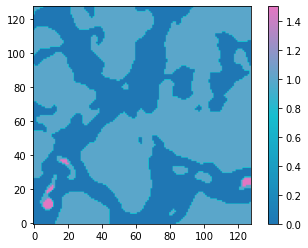

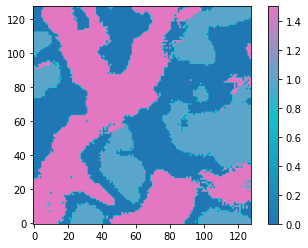

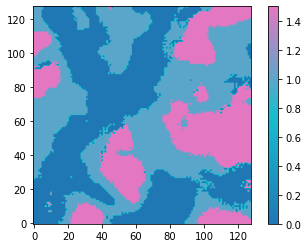

In [14]:
'''
Hacky way to *try* to set dark blue for igr, light blue gr, pink bp
'''
algseg = np.load(f'../../WNet_runs/MURaM/WNetM_1A/test_preds_MURaM/true_692.npy')
colors = LinearSegmentedColormap.from_list('', [plt.cm.tab10(0), plt.cm.tab10(9), plt.cm.tab10(6)])
plt.figure(); plt.imshow(algseg, origin='lower', cmap=colors)#'gist_gray')
plt.colorbar()
print(algseg[75, 5], algseg[0,0], algseg[9, 9])


for m in ['WNetX_3A']: #['WNetM_1E']: # 'WNetT_1C'
    idx = 108 if 'T' in m else 692
    preds = np.squeeze(np.load(f'../../WNet_runs/MURaM/{m}/test_preds_MURaM/pred_{idx}.npy'))
    plt.figure(); im0 = plt.imshow(preds, origin='lower', cmap=colors); plt.colorbar(im0)
# #     fig, axs = plt.subplots(1,4,figsize=(15, 3))
# #     im0 = axs[0].imshow(preds, origin='lower', cmap=colors); plt.colorbar(im0)
# #     preds_copy = np.copy(preds)
# #     if preds_copy[0,0] != 0.0: 
# #         print(f'preds_copy[0.0] = {preds_copy[0,0]}, not 0, so setting preds to 0 where preds_copy is {preds_copy[0,0]}')
# #         igr_num = preds_copy[0,0]
# #         preds[preds_copy == igr_num] = 0.0
# #     axs[1].imshow(preds, origin='lower', cmap=colors)
# #     if preds_copy[75,5] != 1.0: #[80,0] [60,127] 
# #         print(f'preds_copy[75,5] = {preds_copy[75,5]}, not 1, so setting preds to 1 where preds_copy is {preds_copy[75,5]}')
# #         gr_num = preds_copy[75,5]
# #         preds[preds_copy == gr_num] = 1.0
# #     axs[2].imshow(preds, origin='lower', cmap=colors)
# #     if preds_copy[9,9] != 1.5:
# #         print(f'preds_copy[9,9] = {preds_copy[9,9]}, not 1.5, so setting preds to 1 where preds_copy is {preds_copy[75,5]}')
# #         bp_num = preds_copy[9,9]
# #         preds[preds_copy == bp_num] = 1.5 
# #     axs[3].imshow(preds, origin='lower',  cmap=colors)
#     reg_a = np.where(preds == 0.0)
#     reg_b = np.where(preds == 1.0)
#     reg_c = np.where(preds == 1.5)   
#     cur_bp_num = 0.0 if len(reg_a) < len(reg_b)
#     out = np.empty_like(preds)
    if 'T' in m:
        out[preds == 1.5] = 0.0
        out[preds == 0.0] = 1.0
        out[preds == 1.0] = 1.5
    if 'M' in m:
        out[preds == 1.0] = 0.0
        out[preds == 1.5] = 1.0
        out[preds == 0.0] = 1.5
    if 'X' in m:
        out[preds == 1.5] = 0.0
        out[preds == 0.0] = 1.0
        out[preds == 1.0] = 1.5
    plt.figure(); imf = plt.imshow(out, origin='lower', cmap=colors); plt.colorbar(imf)

(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
(2, 128, 128)
torch.Size([16, 2, 128, 128])


NameError: name 'b' is not defined

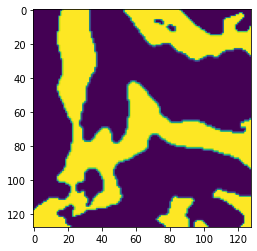

In [8]:
'''
Saved trues are all 0s?
'''
import importlib
importlib.reload(data_utils)
from torch.utils.data import Dataset, TensorDataset, DataLoader
test_ds = data_utils.dataset(image_dir="UNetData_MURaM/norm_images/", mask_dir="UNetData_MURaM/seg_images/", set='val', norm=False, n_classes=2, channels=['X'], randomSharp=False, im_size=128) # multichannel=True, channels=['deltaBinImg'],
test_loader = DataLoader(test_ds, batch_size=16, pin_memory=True, shuffle=False)
model = models.WNet(squeeze=2, ch_mul=64, in_chans=1, out_chans=2, kernel_size=3, padding_mode='replicate', reconstruct_mag=False)
model.load_state_dict(torch.load(f'../../WNet_runs/MURaM/WNetX_bin1A/WNetX_bin1A.pth'))
for X, y in test_loader:
    X, y = X.to('cpu'), y.to('cpu')
    print(y.shape)
    plt.imshow(y[0,0,:,:])      

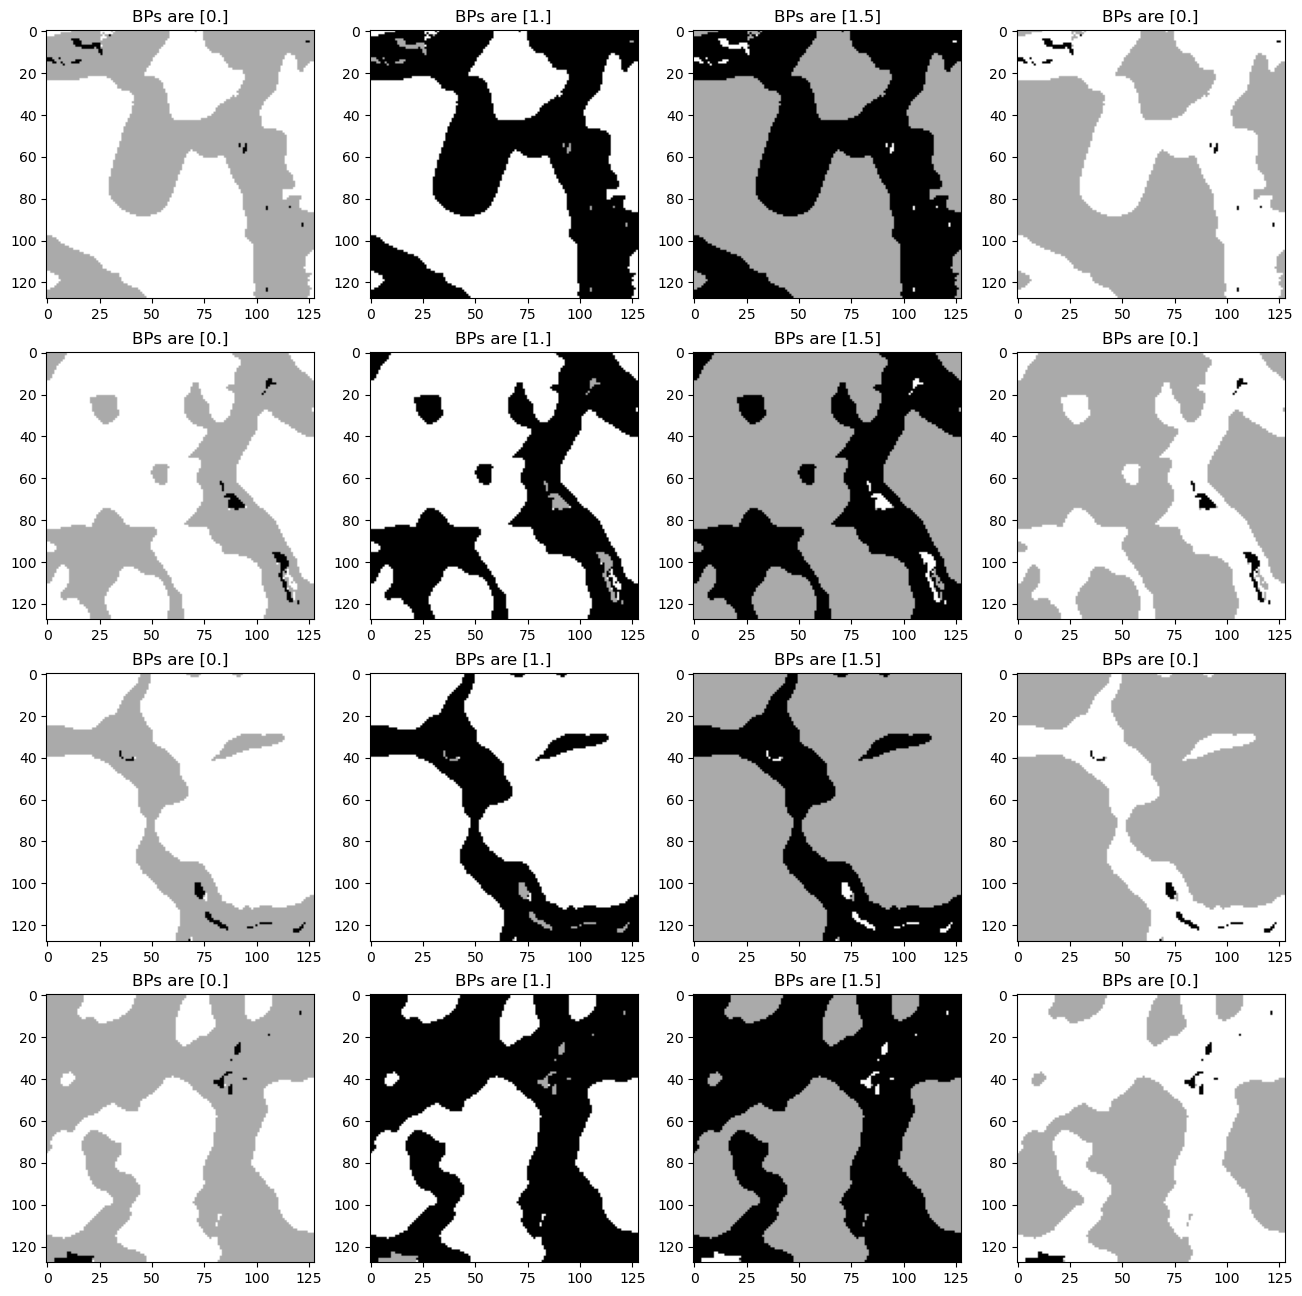

In [46]:
'''
Try to develop more robust way to set consistent class numbering
'''
n = 4
fig, axs = plt.subplots(len(mocks), n, figsize=(n*4,len(mocks)*4))
for j in range(n):
    idx = np.random.choice(np.linspace(0,700,dtype=int),1)[0]
    predA = np.squeeze(np.load(f'../../model_runs_seg/MURaM/WNetM_1E/test_preds_MURaM/pred_{idx}.npy')) # 692 # for binary 'WNetX_bin1B'
    predB = np.copy(predA)
    predB[predA == 0.0] = 1.0
    predB[predA == 1.0] = 0.0
    predC = np.copy(predA)
    predC[predA == 0.0] = 1.5
    predC[predA == 1.0] = 0.0
    predC[predA == 1.5] = 1.0
    predD = np.copy(predA)
    predD[predA == 1.0] = 1.5
    predD[predA == 1.5] = 1.0
    mocks = [predA, predB, predC, predD]
    for i in range(len(mocks)):
        preds = mocks[i]
        unique, counts = np.unique(preds, return_counts=True)
        bp_num = unique[counts == np.min(counts)][0]
        axs[j,i].imshow(preds, cmap='gist_gray')
        axs[j,i].set_title(f'BPs are {bp_num}')#(f'IGR are {}, GR are {}, BPs are {bp_num}')


In [10]:
# typ = 'mag'
# raw_newdir =  '../../Data/MURaM_mag'
# startswith = 'tau' if typ == 'mag' else ''
# norm_tag = 'full'

d = '../../Data/UNetData_MURaM/fullnorm_vx_images/'
rm_files = [f for f in os.listdir(d) if 'vx.fits' in f]
for f in rm_files:
    os.remove(f'{d}/{f}')

In [ ]:
'''
Why does running on new normalized data (full series normalization) make WNet with mag info not work!?!
'''
import sys, json, importlib
sys.path.insert(0, '../utils')
import data_utils, run_utils, models, loss_funcs
sys.path.insert(0, '../')
import run_WNet
importlib.reload(data_utils); importlib.reload(run_WNet); importlib.reload(loss_funcs)

# Analogous models 
exp_dict = json.load(open('../../model_runs_seg/MURaM/WNetM_1E/exp_file.json'))
exp_dict_fn = json.load(open('../../model_runs_seg/MURaM/WNetMfn_1Eb/exp_file.json'))
#print(f'image norm exp_file\n{exp_dict}\nfull norm exp_file\n{exp_dict_fn}')

for d in [exp_dict, exp_dict_fn]:
    print(f'{d["WNet_name"]}')
    channels = d['channels'] 
    train_ds = data_utils.dataset(image_dir=d['img_dir'], mask_dir=d['seg_dir'], set='train', norm=False, n_classes=d['n_classes'], channels=channels, randomSharp=d['randomSharp'], im_size=d['img_size'], add_mag=False, inject_brightmasks=False) # multichannel=True, channels=['deltaBinImg'], 
    train_loader = DataLoader(train_ds, batch_size=d['batch_size'], pin_memory=True, shuffle=True)
    in_channels = len(channels); out_channels = in_channels
    model = models.WNet(squeeze=d['n_classes'], ch_mul=64, in_chans=in_channels, out_chans=out_channels, kernel_size=d['kernel_size'], padding_mode=d['padding_mode'], reconstruct_mag=False, pretrained_dec="None").to(torch.device('cpu'))
    optimizer = torch.optim.SGD(model.parameters(), lr=d["learning_rate"])
    for epoch in range(1): #d['num_epochs']): 
        #enc_losses, rec_losses = run_utils.train_WNet(train_loader, model, optimizer, k=d['n_classes'], img_size=(d['img_size'], d['img_size']), exp_outdir=exp_outdir, WNet_id=WNet_id, smooth_wght=d['smooth_wght'], blob_wght=d['blob_wght'], ncut_wght=d['ncut_wght'], epoch=epoch,  device=device, target_pos=0, weights=d['weights'], reconstruct_mag=d['reconstruct_mag'], save_examples=False, temp_dir=exp_outdir)      
        for (idx, batch) in enumerate(train_loader):
                X = batch[0] # batch is [images, labels]
                #wnet, enc_loss, rec_loss, enc, dec = train_wnet_batch(wnet, optimizer, X, k, img_size=img_size, smooth_wght=smooth_wght, ncut_wght=ncut_wght, blob_wght=blob_wght, device=device, freeze_dec=freeze_dec, target_pos=target_pos, weights=weights, debug=debug, reconstruct_mag=eval(str(reconstruct_mag)), epoch=epoch, temp_dir=temp_dir)
                softmax = nn.Softmax2d(); soft_n_cut_loss = run_utils.get_loss_func('soft_n_cut_loss'); smoothLoss = run_utils.get_loss_func('OpeningLoss2D'); blobloss = run_utils.get_loss_func('blobloss'); multichannel_MSE_loss = run_utils.get_loss_func('multichannel_MSE_loss')
                model_input = X.to('cpu')
                enc = model(model_input, compute_dec=False) # predict seg of k classes 
                n_cut_loss = soft_n_cut_loss(input, softmax(enc),  img_size=d['img_size']) # if reconstruct_mag, include mag channel in assesment of intra-cluster similarity
                enc_loss = ncut_wght*n_cut_loss + blob_wght*blobloss(enc, temp_dir=temp_dir) + smooth_wght*smoothLoss(softmax(enc))
                enc_loss.backward() 
                optimizer.step()
                optimizer.zero_grad()
                rec = model(model_input, compute_dec=True) # predict image (all channels)
                rec_loss = multichannel_MSE_loss(input, rec, weights) # if reconstruct_mag, include mag channel in assesment of reconstruction accuracy (rec will have n_channels + 1 layers)   # from reproduction (MSELoss betwn input and rec imag) BUT with added channel weights
                rec_loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                print(f'({enc_loss.detach()},{rec_los.detach()}) ', end='')
                
                
# run_WNet.run_wnet_model(d, gpu='False', test_only=False)
# run_WNet.run_wnet_model(d, gpu='False', test_only=False)

WNetM_1E


In [39]:
files = [f for f in os.listdir('../../Data/MURaM_mag/') if 'Norm_' in f and f.startswith('fullNorm')==False]
#print(files)
for f in files:
    os.remove(f'../../Data/MURaM_mag/{f}')

In [42]:
os.path.exists('../../Data/UNetData_MURaM/norm_images/val/001400__1.npy')

False